# Environment Setup

In [ ]:
# Import Libraries and Set Random State
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
import sys
import os
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import matplotlib.pyplot as plt

## Ensure TensorFlow is not used
os.environ["USE_TF"] = "0"

## Set Random State
random_state = 42

In [ ]:
# Import Hugging Face Tooling
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate
from datasets import Dataset

# Device Setup

In [3]:
# Use CPU/MPS if possible
device = None
if "google.colab" in sys.modules:
    # Running in Colab
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    # Not in Colab (e.g., Mac)
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print("Using device:", device)

Using device: mps


# Data Analysis

## Remove Duplicates from Original Dataset

In [4]:
# Load Full Data
PATH = "data/available_metahate.tsv"
df = pd.read_csv(PATH, sep = "\t")
df.head()

,label,text
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
print(f"Num Rows: {df.shape[0]}, Num Cols: {df.shape[1]}")

Num Rows: 1101165, Num Cols: 2


In [6]:
## Drop Duplicate Text posts as a sanity check 
df = df.drop_duplicates(subset = ["text"], keep = "first").reset_index(drop = True)
df.head()

,label,text
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
print(f"Num Rows: {df.shape[0]}, Num Cols: {df.shape[1]}")

Num Rows: 1101165, Num Cols: 2


## Investigate Class Imbalance

In [8]:
# Print Series of label counts to investigate class imbalance
label_counts = df['label'].value_counts()
label_counts

label
0    867876
1    233289
Name: count, dtype: int64

In [9]:
# Convert Series --> DataFrame
label_counts = label_counts.reset_index()
label_counts

,label,count
0,0,867876
1,1,233289


In [10]:
# Change column names
label_counts.columns = ['label', 'count']
label_counts.head()

,label,count
0,0,867876
1,1,233289


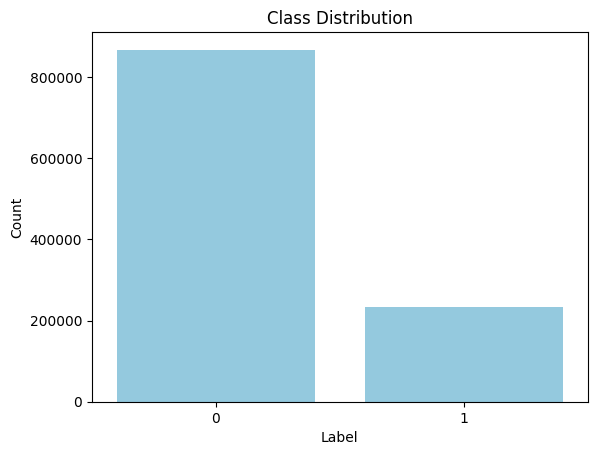

In [11]:
# Plot bar plot showing Class Imbalance
sns.barplot(data=label_counts, x='label', y='count', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Create Train-Dev-Test Splits

In [12]:
df, _ = train_test_split(df, train_size = 0.03, random_state=random_state, shuffle = True, stratify = df['label'])
df.head()

,label,text
727805,0,"It is definitely bullshit, because as a man, y..."
337405,0,:::::::Still you supply no policy. Evidently ...
677565,0,but try to find stupid anti irish messages on ...
1065523,0,::Agreed. I'm trying to salvage the informati...
35654,0,"You may lose your sense of purpose, only to un..."


In [13]:
# First stratified split: train (80%) and temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=random_state, shuffle = True, stratify = df['label'])

# Second stratified split: dev (10%) and test (10%)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_state, shuffle = True, stratify = temp_df['label'])

# Reset index for train
train_df = train_df.reset_index(drop = True)

# Reset index for dev
dev_df = dev_df.reset_index(drop = True)

# Reset index for test
test_df = test_df.reset_index(drop = True)

# Check sizes
print(len(train_df), len(dev_df), len(test_df))

26427 3303 3304


# Save Train-Dev-Test Splits

In [14]:
train_df.to_csv("data/train_data.csv", index = False)
dev_df.to_csv("data/dev_data.csv", index = False)
test_df.to_csv("data/test_data.csv", index = False)

# Load Data

In [15]:
# Load data (must upload first if running on colab)
try:
    train_df = pd.read_csv('/content/train_data.csv')
    dev_df = pd.read_csv('/content/dev_data.csv')
    test_df = pd.read_csv('/content/test_data.csv')
except:
    # If Running on Ravi's laptop
    train_df = pd.read_csv('data/train_data.csv')
    dev_df = pd.read_csv('data/dev_data.csv')
    test_df = pd.read_csv('data/test_data.csv')

# Check
train_df.head()

,label,text
0,0,You have to be born here or go through nationa...
1,0,"Healing Into Life and Death Levine, Stephen Pa..."
2,0,Holding 2 guns isn't difficult unless you're a...
3,0,"As far as I know, too many entries in wikip..."
4,0,RT @HG_Shit: Pull up like look at my shoes bit...


# Simple Baseline: Majority-class Classifier

## Model Setup & Training

In [16]:
# Define a Majority Class Model
class MajorityClassModel:
    def __init__(self):
        self.majority_class = None

    # Fit a Majority Class Model to the dataset
    def fit(self, y_train):
        self.majority_class = y_train.mode()[0]
        print(f"Majority class in training set = {self.majority_class}")

    # Predict the majority class for any given samples
    def predict(self, X):
        return [self.majority_class] * len(X)

# Train a Majority Class Model
model = MajorityClassModel()
model.fit(train_df["label"])

Majority class in training set = 0


## Evaluation

In [ ]:
# --- Compute Metrics (Accuracy, Precision, Recall, and F1 Score) ---
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pos_precision = precision_score(y_true, y_pred, pos_label = 1, zero_division=0)
    pos_recall = recall_score(y_true, y_pred, pos_label = 1, zero_division=0)
    neg_precision = precision_score(y_true, y_pred, pos_label = 0, zero_division=0)
    neg_recall = recall_score(y_true, y_pred, pos_label = 0, zero_division=0)
    pos_f1 = f1_score(y_true, y_pred, average = "binary", pos_label = 1, zero_division=0)
    neg_f1 = f1_score(y_true, y_pred, average = "binary", pos_label = 0, zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    return acc, pos_precision, pos_recall, neg_precision, neg_recall, pos_f1, neg_f1, f1_macro, f1_micro

In [ ]:
# Predict on train, dev, and test values ---
y_pred_train = model.predict(train_df)
y_true_train = train_df["label"].values

y_pred_dev = model.predict(dev_df)
y_true_dev = dev_df['label'].values

y_pred_test = model.predict(test_df)
y_true_test = test_df['label'].values

# Obtain Accuracy, Precision, Recall, and F1 Score for each Split (i.e. Train, Dev, and Test)
train_acc, train_pos_precision, train_pos_recall, train_neg_precision, train_neg_recall, train_pos_f1, train_neg_f1, train_f1_macro, train_f1_micro = compute_metrics(y_true_train, y_pred_train)
dev_acc, dev_pos_precision, dev_pos_recall, dev_neg_precision, dev_neg_recall, dev_pos_f1, dev_neg_f1, dev_f1_macro, dev_f1_micro = compute_metrics(y_true_dev, y_pred_dev)
test_acc, test_pos_precision, test_pos_recall, test_neg_precision, test_neg_recall, test_pos_f1, test_neg_f1, test_f1_macro, test_f1_micro = compute_metrics(y_true_test, y_pred_test)

# Store metrics in Pandas Dataframe
metrics_df = pd.DataFrame({
    "Split": ["Train", "Dev", "Test"],
    "Accuracy": [train_acc, dev_acc, test_acc],
    "Positive Precision": [train_pos_precision, dev_pos_precision, test_pos_precision],
    "Positive Recall": [train_pos_recall, dev_pos_recall, test_pos_recall],
    "Negative Precision": [train_neg_precision, dev_neg_precision, test_neg_precision],
    "Negative Recall": [train_neg_recall, dev_neg_recall, test_neg_recall],
    "Positive F1": [train_pos_f1, dev_pos_f1, test_pos_f1],
    "Negative F1": [train_neg_f1, dev_neg_f1, test_neg_f1],
    "Macro F1": [train_f1_macro, dev_f1_macro, test_f1_macro],
    "Micro F1": [train_f1_micro, dev_f1_micro, test_f1_micro]
})

metrics_df.round(4)

,Split,Accuracy,Precision,Recall,F1
0,Train,0.7882,0.0,0.0,0.0
1,Dev,0.7881,0.0,0.0,0.0
2,Test,0.7881,0.0,0.0,0.0


# Stronger Baseline: MetaHateBERT

### Fine-tuning BERT on the MetaHate Dataset

In this section, we fine-tune a standard **BERT** model on the **MetaHate dataset** to replicate the results reported in the *MetaHate* paper.  
Our objective is to **reproduce the baseline performance metrics** presented in the original study, which will serve as a **reference point** for our project.

To address **compute limitations**, we fine-tune on a **3% stratified sample** of the dataset, ensuring that the **label proportions** remain consistent with the full dataset.


## Fetch BERT Model from HuggingFace

In [19]:
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels = 2) # num_labels = 2 since we have 2 classes!

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create `Hugging Face` Datasets [Train + Dev + Test]

In [ ]:
train_hf_dataset = Dataset.from_pandas(train_df)
dev_hf_dataset = Dataset.from_pandas(dev_df)
test_hf_dataset = Dataset.from_pandas(test_df)

## Tokenize Text Data

In [ ]:
def tokenize_function(row):
  tokens = tokenizer(row['text'], truncation = True, padding = 'max_length', max_length = tokenizer.model_max_length)
  row['input_ids'] = tokens['input_ids']
  row['attention_mask'] = tokens['attention_mask']
  row['token_type_ids'] = tokens['token_type_ids']
  return row

train_hf_dataset = train_hf_dataset.map(tokenize_function)
dev_hf_dataset = dev_hf_dataset.map(tokenize_function)
test_hf_dataset = test_hf_dataset.map(tokenize_function)

## Define a `compute_metrics` function

In [ ]:
# Define Accuracy, Precision, Recall, and F1 Metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load('recall')
f1_metric = evaluate.load("f1")

# Define a compute_metrics function
def compute_metrics(eval_pred):
    # Get the model predictions
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions, labels),
        "pos_precision": precision_metric.compute(predictions, labels, pos_label = 1, average = 'binary', zero_division = 0), # Precision on the Class w/ Label = 1 [Hate Samples]
        "pos_recall": recall_metric.compute(predictions, labels, pos_label = 1, average = 'binary', zero_division = 0), # Recall on the Class w/ Label = 1 [Hate Samples]
        "pos_f1": f1_metric.compute(predictions, labels, pos_label = 1, average = 'binary'), # F1 Score on the Class w/ Label = 1 [Hate Samples]
        "neg_precision": precision_metric.compute(predictions, labels, pos_label = 0, average = 'binary', zero_division = 0), # Precision on the Class w/ Label = 0 [Non-Hate Samples]
        "neg_recall": recall_metric.compute(predictions, labels, pos_label = 0, average = 'binary', zero_division = 0), # Recall on the Class w/ Label = 0 [Non-Hate Samples]
        "neg_f1": f1_metric.compute(predictions, labels, pos_label = 0, average = 'binary'), # F1 Score on the Class w/ Label = 0 [Non-Hate Samples]
        "f1_macro": f1_metric.compute(predictions=predictions, references=labels, average='macro'), # Macro F1 Score
        "f1_micro": f1_metric.compute(predictions=predictions, references=labels, average='micro'), # Micro F1 Score
        "f1_weighted": f1_metric.compute(predictions=predictions, references=labels, average='weighted'), # Weighted F1 Score
    }

## **Initialize the `TrainingArguments` and `Trainer`**

In [ ]:
training_args = TrainingArguments(
    output_dir="Milestone2-Baseline-BERT-FineTuning",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=3,
    save_strategy="steps",      # save checkpoints every N steps
    save_steps=100,             # save every 100 steps
    eval_strategy="steps",      # evaluate every N steps
    eval_steps=100,             # evaluate every 100 steps
    logging_strategy="steps",
    logging_steps=100,          # log every 100 steps
    save_total_limit=5,         # keep only the last 5 checkpoints
    report_to="none",
    full_determinism=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hf_dataset,
    eval_dataset=dev_hf_dataset,
    compute_metrics=compute_metrics,
)

## **Train the Model: `Fine-Tuning`**

In [ ]:
trainer.train(resume_from_checkpoint = True) # Always Resume from Last Checkpoint to Save Time
trainer.save_model('Milestone2-Baseline-BERT-FinalModel') # Save the Final Model
trainer.save_state() # Save the State of the Trainer (e.g. Losses, etc)

## **Evaluate on Train, Dev, and Test Datasets**

In [ ]:
# Split: Train, Dev, or Test
def generate_evaluation_results(split):
    dataset = None
    if split == "train":
        dataset = train_hf_dataset
    elif split == "dev" or split == "validation" or split == "val":
        dataset = dev_hf_dataset
    elif split == "test":
        dataset = test_hf_dataset
    
    results = trainer.evaluate(eval_dataset=dataset, metric_key_prefix=split)
    df_results = pd.DataFrame([results])
    df_results.to_csv(f"data/BERT_baseline_{split}_results.csv", index=False)
    print(f"Saved {split} evaluation metrics to data/BERT_baseline_{split}_results.csv")

In [ ]:
# Generate Evaluation Results on Train, Dev, and Test Splits
generate_evaluation_results("train")
generate_evaluation_results("dev")
generate_evaluation_results("test")